In [1]:
# Miscellaneous
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots
from wordcloud import WordCloud

# Sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans # Clustering
from sklearn.feature_extraction.text import TfidfVectorizer

# Deep learning
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Libraries for NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

# custom methods
from utils import category_ngram, plot_history, plot_cmatrix, display_wordcloud, aut_frequency, plot_bars_authors

# Others
import os
import re

# Seaborn style
sns.set_style('whitegrid')
# Matplot style 
plt.style.use('ggplot')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sherlock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sherlock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sherlock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Dataset Description

The file contains 202,372 records. Each json record contains following attributes:

-  `category`: Category article belongs to
-  `headline`: Headline of the article 
-  `authors`: Person authored the article
-  `link`: Link to the post
-  `short_description`: Short description of the article
-  `date`: Date the article was published


# First Question

¿Se pueden catalogar las noticias con la descripción y los titulares? Compara tu
clasificación con las categorías incluidas en el set de datos.

Yes, it is possible to do such thing as the `description` and `headlines` can be used as features in a classification task where the targets are the `categories`. The next cells will attemp to adress this question.

The next step is to load the dataset

In [2]:
# Loading the dataset
news_category = pd.read_json('dataset/News_Category_Dataset_v2.json', lines=True)
# Shuffling the dataset (good practice)
news_category = news_category.sample(frac=1).reset_index(drop=True)
print('The dataset shape is {}'.format(news_category.shape))
news_category.head(10)

The dataset shape is (200853, 6)


,category,headline,authors,link,short_description,date
0,POLITICS,California To Challenge Trump's Executive Orde...,Mollie Reilly,https://www.huffingtonpost.com/entry/californi...,"The president's move could be ""disastrous"" to ...",2017-04-28
1,WORLD NEWS,Japan Calls For 'World Without Nuclear Weapons...,Kimberly Yam,https://www.huffingtonpost.com/entry/hiroshima...,Hundreds of thousands died after the U.S. bomb...,2017-08-07
2,COMEDY,TV Characters In Halloween Costumes: The Super...,,https://www.huffingtonpost.com/entry/tv-charac...,Looking to TV characters for Halloween costume...,2012-10-20
3,FOOD & DRINK,How To Make Homemade Extracts,,https://www.huffingtonpost.com/entry/homemade-...,Flavored extracts are a great way to add flavo...,2012-07-09
4,TRAVEL,Ready for Their Close-up: 4 Hometown B&B's of ...,"BnBFinder.com, ContributorBnBFinder",https://www.huffingtonpost.com/entry/ready-for...,Since the film awards season is well under way...,2015-02-19
5,STYLE & BEAUTY,Kim Kardashian's Cleavage At 'Du Jour' Magazin...,Jessica Misener,https://www.huffingtonpost.com/entry/kim-karda...,Kim Kardashian's body is legendarily amazing -...,2012-09-06
6,HOME & LIVING,60-Second Centerpieces,,https://www.huffingtonpost.comhttp://www.reals...,Transform your table with these simple yet bea...,2013-05-22
7,CRIME,"One Ton Of Marijuana, Worth More Than $7 Milli...",Andy Campbell,https://www.huffingtonpost.com/entry/one-ton-o...,A K-9 unit alerted officers to the smell of ma...,2012-03-31
8,ENTERTAINMENT,"From 'Happy Days' To 'Louie,' 8 Of The Best Ga...",Matthew Jacobs,https://www.huffingtonpost.com/entry/garry-mar...,"Commemorate the famed director, who died Tuesday.",2016-07-20
9,QUEER VOICES,What Would Happen If The Disney Princes Were Q...,James Michael Nichols,https://www.huffingtonpost.com/entry/what-woul...,Are you sure you're ready for this?,2015-12-19


This dataset contains a total of 6 features and 200853 samples (which is a lot!).


For a further dig into the dataset, the function ``describe`` of pandas is used. There we can see samples the number of unique categories which are 41. Additionally, It is possible to see that there are repeated headlines, authord and short_descriptions. The last information will be used to filter the dataset.

In [3]:
# Describe info of the dataset
news_category.describe()

<ipython-input-3-c99a2d68ffff>:2: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



,category,headline,authors,link,short_description,date
count,200853,200853,200853,200853,200853,200853
unique,41,199344,27993,200812,178353,2309
top,POLITICS,Sunday Roundup,,https://www.huffingtonpost.comhttp://www.cnn.c...,,2013-01-17 00:00:00
freq,32739,90,36620,2,19712,100
first,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
last,NaN,NaN,NaN,NaN,NaN,2018-05-26 00:00:00


Another important step is to check for Null or NaN values. Although it was already seen with the `describe` method that there is not NaN, The following cell prints the sum of NaN in the dataset.

In [4]:
# Checking for NaNs
news_category.isna().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

The next cell prints all the categories within the dataset, this is a very good insight about the number of categories and their names.

In [5]:
# Print unique categories
print('The Categories in the dataset are: \n')
print(news_category.category.unique())
print('The total number of features are: {}'.format(len(news_category.category.unique())))

The Categories in the dataset are: 

['POLITICS' 'WORLD NEWS' 'COMEDY' 'FOOD & DRINK' 'TRAVEL' 'STYLE & BEAUTY'
 'HOME & LIVING' 'CRIME' 'ENTERTAINMENT' 'QUEER VOICES' 'WELLNESS'
 'IMPACT' 'GREEN' 'DIVORCE' 'HEALTHY LIVING' 'BUSINESS' 'BLACK VOICES'
 'WEIRD NEWS' 'PARENTING' 'WEDDINGS' 'CULTURE & ARTS' 'WOMEN' 'TECH'
 'GOOD NEWS' 'ARTS' 'THE WORLDPOST' 'RELIGION' 'TASTE' 'STYLE' 'MEDIA'
 'SPORTS' 'FIFTY' 'SCIENCE' 'MONEY' 'PARENTS' 'WORLDPOST' 'ENVIRONMENT'
 'LATINO VOICES' 'EDUCATION' 'COLLEGE' 'ARTS & CULTURE']
The total number of features are: 41


From before we can see that there are a total of 41 unique categories in the dataset. These categories need to be processed to be used in further steps in a classifier.

To see what a `short_description` looks like, the next line prints one.

In [6]:
print('A short description: "{}"'.format(news_category.iloc[7]["short_description"]))

A short description: "A K-9 unit alerted officers to the smell of marijuana, which led them to the big find: 2,500 pounds packed inside tubes in"


### Visualizing data

To gain more insights about the dataset, I will plot the number of samples belonging to an specific category in a barplot. This will plot will show if the datasetet is balanced.

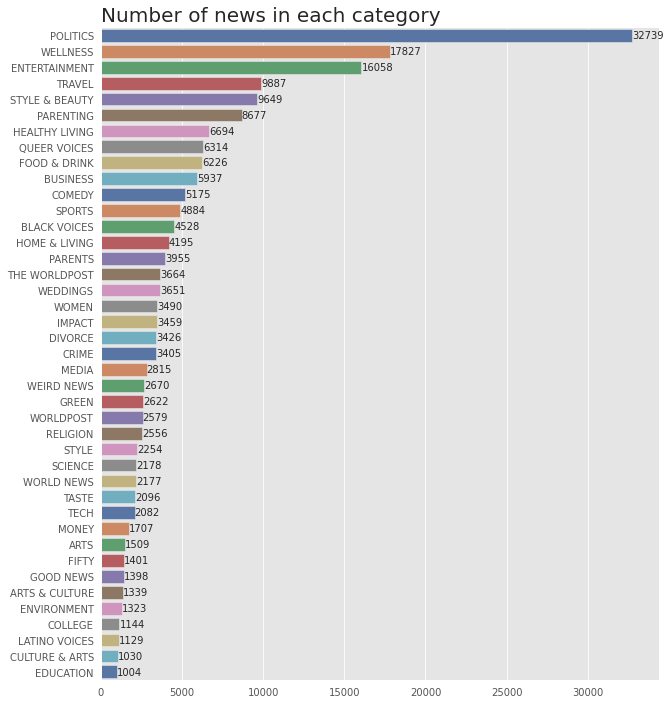

In [7]:
# Create new dataframe
bars_df = pd.DataFrame(news_category['category'].value_counts()).reset_index()
# Plotting
plt.figure(figsize=(10, 12))
bars = sns.barplot(data = bars_df, y = 'index', x = 'category', palette='deep')
plt.title('Number of news in each category', loc='left', fontsize=20)
plt.xlabel("")
plt.ylabel("")
ax = bars
# Adding values in each bar 
# https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 1,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.0f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment
    
plt.show()

From the last plot we can see that the `category` "Politics" is the most common one in the dataset. Moreover, the category with less samples is `Education`, however, it seems to be a reasonable value to train a neural network. The last Barplot give us considerable good insights about what are the most frequent categories in the dataset. Additionally the `categories` ranging from "Media" to "Education" have similar values which might useful to know before training a model.

Another interesting insight would be the average lenght of the `headlines` and `descriptions` in the dataset, to do so, a probability, dense function will be plotted for each of these features.

In [12]:
# Use plotly to see the distribution of categorical data
# https://www.kaggle.com/vikashrajluhaniwal/recommending-news-articles-based-on-read-articles#6.-Headline-based-similarity-on-new-articles
fig = ff.create_distplot([news_category['headline'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Headline lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of a headline",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'headline.html')

'headline.html'

The last plot shows the univariate or bivariate distribution with a kernel density estimate. This plot is useful as it presents how are distributed the lenght of the `headline` feature. In fact, most of the text in this feature is condensed between 90 and 70 characters lenght. Therefore, if we were going train a model using only this feature, there would be approximately 80 characters-long. 

Similarly, it is also possible to plot the lenght of the `short_description`.

In [13]:
# Use plotly to see the distribution of categorical data

fig = ff.create_distplot([news_category['short_description'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Description lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of Description",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500).
plotly.offline.plot(fig, filename = 'short_description.html')

'short_description.html'

The text-lenght for the `short_description` feature is roughly 200 characters long. It is also possible to see that the text's average lenght in the `headline` and in the `short_description` are quite different. Generally, the text in the description is way longer and may provide more information for a classification task.

### Filtering the dataset

The following cells will be used to filter the text within the `headline` and `short_description` features. 

These lines of code are for testing purpose, and filter the dataset based on the most recent data. This is done due to computational resources as working with the whole dataset might be extremely slow. I will use data ranged only from 2017/05/05 and above. The resulting dataset will be stored in a different dataframe called `news_articles`.

In [14]:
# Filter dataset by date
f_articles = news_category[news_category['date'] >= pd.Timestamp(2017,5,5)]
#f_articles = news_category.copy()
print('The shape of the filtered dataset is: {}'.format(f_articles.shape))

The shape of the filtered dataset is: (27487, 6)


One drawback from the past lines are that the dataset now has less categories. To validate this, the next cell prints the new list of categories.

In [15]:
# Print unique categories
print('The Categories in the dataset are: \n')
print(f_articles.category.unique())
print('The total number of features are: {}'.format(len(f_articles.category.unique())))

The Categories in the dataset are: 

['WORLD NEWS' 'CRIME' 'POLITICS' 'QUEER VOICES' 'WOMEN' 'COMEDY'
 'BLACK VOICES' 'PARENTS' 'SPORTS' 'RELIGION' 'MEDIA' 'ENTERTAINMENT'
 'BUSINESS' 'SCIENCE' 'STYLE' 'GREEN' 'THE WORLDPOST' 'HEALTHY LIVING'
 'WEIRD NEWS' 'EDUCATION' 'TRAVEL' 'LATINO VOICES' 'TASTE'
 'ARTS & CULTURE' 'TECH' 'COLLEGE' 'IMPACT' 'GOOD NEWS']
The total number of features are: 28


Our new sampled dataset now has only 28, in comparison agains the whole dataset with 41 categories.

An important step is to remove headlines and descriptions with less than five words. Additionally, as mentioned before there are repeated headlines and short descriptions, thus, it is neccessary to remove these repeated texts.

In [16]:
# Filter headlines with less than 5 characters
f_articles = f_articles[f_articles['headline'].apply(lambda x: len(x.split())>5)]
f_articles = f_articles[f_articles['short_description'].apply(lambda x: len(x.split())>5)]
# Filter headlines in a descending manner
f_articles.sort_values('headline',inplace=True, ascending=False)
# Make a copy of the dataset
duplicated_headlines_series = f_articles.duplicated('headline', keep = False)
# Remove repeated headlines 
news_articles = f_articles[~duplicated_headlines_series]
# Make another copy of the dataset
duplicated_description_series = f_articles.duplicated('short_description', keep = False)
# Remove repeated descriptions 
news_articles = f_articles[~duplicated_description_series]
print("Total number of articles after removing duplicates (headlines):", f_articles.shape[0])

Total number of articles after removing duplicates (headlines): 24274


In [26]:
print("Total number of articles : ", f_articles.shape[0])
print("Total number of authors : ", f_articles["authors"].nunique())
print("Total number of unqiue categories : ", f_articles["category"].nunique())

Total number of articles :  24274
Total number of authors :  3922
Total number of unqiue categories :  28


After filtering, we ended up with 24274 samples which are 3213 less samples than the ones we originally had.

It is interesting to visualize the number of articles per date, the next cell shows the aforementioned.

In [17]:
# Articles per month
news_articles_per_month = f_articles.resample('m', on = 'date')['category'].count()
news_articles_per_month

date
2017-05-31    2006
2017-06-30    2273
2017-07-31    2129
2017-08-31    2254
2017-09-30    2027
2017-10-31    2084
2017-11-30    1934
2017-12-31    1765
2018-01-31    1856
2018-02-28    1543
2018-03-31    1652
2018-04-30    1480
2018-05-31    1271
Freq: M, Name: category, dtype: int64

From the past cell, I can conclude that the data is well distributed among the given dates.

Now is time to remove the stopwords, as this is a dataset in English, I will use the stopwords provided in the library `stopwords`

In [18]:
# remove stop words
stop_words = set(stopwords.words('english'))
# List of stopwords to filter
print(stop_words)

{'him', 'during', 'some', 'where', 'over', 'an', "mustn't", "you'll", 'couldn', 'does', 'for', 'which', "it's", "hasn't", 'you', 'both', 'below', 'as', 'ourselves', 'while', 'other', 'needn', "you're", 'own', "hadn't", 'because', 'very', 'until', "she's", 'most', 'it', 'o', 'myself', 'how', 're', 'isn', "you'd", 'with', "you've", 'were', "doesn't", 'been', 'our', 'any', 'and', 'should', 't', 'nor', "haven't", 'now', 'about', 'm', 'in', 'between', 'will', 'didn', "couldn't", 'd', 'once', 'he', 'ours', 'here', 'i', 'after', 'theirs', 'her', 'ain', 'yourselves', 'be', 'doing', 'll', 'have', 'few', 'did', 'the', 'why', 'yours', 'had', 'same', 'shouldn', 'up', 'no', 'me', 'what', 'all', 'hers', 'itself', 'on', "mightn't", 'their', 'being', 'too', 'this', "isn't", 'those', 'your', 'am', 'hadn', 'has', 'himself', 'she', 'herself', 'off', 'again', 'each', 'doesn', "that'll", 'so', "don't", 'from', 'who', 'down', 'hasn', 'wasn', 'a', 'its', 'do', 'there', 'y', "wouldn't", "shouldn't", "needn't"

The following functions are used to create some filters for the dataset. The method `remove_stopwords` is used to remove stop words, `alpha_num` removes any character that is not alphanumeric, finally, `rem_lemmatizer` converts the words to its base form. These three basic filters are extremely useful when processing text within a dataset and can considerable improve performance.

In [19]:
# Removing stopwords
def remove_stopwords(text):
    final_text = []
    # Split text
    for i in text.split():
        # Check if word is not in stopword, otherwise do not append
        if i.strip().lower() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

In [20]:
# Remove non alphanumeric characters
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)

In [21]:
# Lemmatize words to its base form
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
lemmatizer = WordNetLemmatizer()
def rem_lemmatizer(text):
    final_text = []
    string_l = ""
    for w in word_tokenize(text):
        string_l += lemmatizer.lemmatize(w, pos = "v") + " "
    final_text.append(string_l.strip())
    return " ".join(final_text)

Once our filters are defined it is time to apply it to the dataset to the `headline`, `short_description` and `category` features. One step that is doing inplace is to convert all the caracters to lowercase. When the dataset is showed, it is possible to validate how all the filters are successfully parsed applied.

In [22]:
# Headline filtering
# Lowercase
f_articles['headline'] = f_articles['headline'].str.lower()
# Remove stopwords
f_articles['headline'] = f_articles['headline'].apply(remove_stopwords)
# Remove non alphanumerics
f_articles['headline'] = f_articles['headline'].apply(alpha_num)
# Lemmatizer
f_articles['headline'] = f_articles['headline'].apply(rem_lemmatizer)

# Description filtering
f_articles['short_description'] = f_articles['short_description'].str.lower()
f_articles['short_description'] = f_articles['short_description'].apply(remove_stopwords)
f_articles['short_description'] = f_articles['short_description'].apply(alpha_num)
f_articles['short_description'] = f_articles['short_description'].apply(rem_lemmatizer)
# Category (lowercase)
f_articles['category'] = f_articles['category'].str.lower()

f_articles.head()

,category,headline,authors,link,short_description,date
3766,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18
135548,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02
129135,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31
77582,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19
32551,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20


Now it is time to define the features that are going to be Tokenized. There are two ways to do such thing. The **first** one is to Tokenize each feature (with same vectore lenght) and then concatenate the vectors. The **second** option is to blend the strings into a longer one and thus, avoiding the need of two tokenization steps. Based on my analysis I decided to use the second opion.

To simplify the problem the `headline` and `short_description` text are blended together and used as a unified feature. This new feature is called `full_text`.

In [23]:
# Combining text
f_articles["full_text"] = f_articles["headline"].map(str) + " " + f_articles["short_description"]
f_articles.head()

,category,headline,authors,link,short_description,date,full_text
3766,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18,to bone didnt teach glamour teach respect ofte...
135548,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02,will grace creator donate gay bunny book every...
129135,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31,we blood invisible live indias dalit women gir...
77582,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19,wannacry ransomware attack raise alarm bell ci...
32551,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20,walk dead reportedly cancel comiccon press eve...


The dataframe presented above has one additionall feature as expected.

An example of how a full text looks like is shown below.

In [25]:
print('The fused text is: "{}"'.format(f_articles.iloc[0]["full_text"]))

The fused text is: "to bone didnt teach glamour teach respect oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance"


It is also important to see the most common words based on a particle category. To do so, the method `category_ngram` prints the top-10 most frequent words of a given category (the method arguments can be different as will be showed in further cells).

In [27]:
# Printing top-10 most frequent words in category 'politics'
category_ngram('politics', 1, f_articles, 'category', 'headline')

,index,frequency
0,trump,3228
1,say,609
2,donald,549
3,gop,452
4,house,423
5,white,367
6,us,357
7,new,333
8,health,305
9,bill,296


### Tokenizing data

Now it is time to parse the data for the classification Task, the first part is to convert the data into numpy arrays. The target will be the `categories` and the features the `headline` and `short_description` blended in the `full_text` feature.

In [28]:
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])

Now we will print the shape of `seq_text` which should has dimensions equal to the number of samplesin the dataframe

In [29]:
# Printing the shape and a text 
print('The shape of the numpy array is: {}'.format(seq_text.shape))
print('The shape of the dataframe is: {}'.format(f_articles.shape))
print('A text example: "{}"'.format(seq_text[0]))

The shape of the numpy array is: (24274,)
The shape of the dataframe is: (24274, 7)
A text example: "to bone didnt teach glamour teach respect oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance"


### Encoding the data

Now comes one of the most important steps and this is the encoding of the labels. As the Labels of this problem are categorical, we need to create a numeric representation. To do so, `sklearn` LabelEncoder is employed. This method assign a unique class label per each categoric feature. As we have 28 features we expect labels ranging from 0 to 28.

In [30]:
# Encoding categories
label_encoder = LabelEncoder()
# Fir the encoder
labels = label_encoder.fit_transform(labels)

The lenght of the labels must match the lenght of the catories. This information is verifies below. 

In [31]:
print('The lenght of the labels are: {}'.format(len(np.unique(labels))))
print('The labels are: {}'.format(np.unique(labels)))

The lenght of the labels are: 28
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


The following lines define the model's parameters overall these are given as follows.

-  vocab_size: the lenght of the vocabulary
-  embedding_dim: The size of the embedding dimension
-  lstm_dim: Number of LSTM units
-  hidden_dim: Number of hidden units (Dense layers)
-  max_length: The maximum lenght of the tokenize word
-  padding_type: Where to pad the vector, after or before
-  oov_tok: Token used to replace out-of-vocabulary of the words

In [32]:
# Parameters
# Size of the vocabulary
vocab_size = 2000
# Dimmension of the embedding 
embedding_dim = 128
# LSTM dim
lstm_dim = 32
# hidden dim (fully connected)
hidden_dim = 64
# Maximum lenght of the tokenized vector
max_length = 120
# Padd the vector after the sequence
padding_type ='post'
# Used to replace out-of-vocabulary words
oov_tok = "<OOV>"

Here is the `train_test_split` of the dataset to have a validation dataset. The 30% of the dataset will be used for validating the final results.

In [33]:
# split the dataset
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(seq_text, labels, 
                                                                                          test_size=0.3, 
                                                                                          stratify=labels)

In [34]:
print('The lenght of the training set is: {}'.format(train_sentences.shape))
print('The lenght of the validation set is: {}'.format(validation_sentences.shape))

The lenght of the training set is: (16991,)
The lenght of the validation set is: (7283,)


Here is where the magic happens and the words are tokenized. To do so, Keras' Tokenizer method is used. This method will automatically create the tokenized vectors with a specified lengh, padding method, etc. It is important to recall that all the parameters were set before, if you forget it go up and take a look!

In [36]:
# Transform text into a vector
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fir to the train sequence
tokenizer.fit_on_texts(train_sentences)
# Dictionary with the index of each word
word_index = tokenizer.word_index

# Transform train dataset to sequence 
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Pad the sequence to the desired shape (given above)
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

# Vectorize and Padd validation dataset
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen = max_length)

In [38]:
print('The shape of the tokenized validation dataset is: {}'.format(validation_padded.shape))

The shape of the tokenized validation dataset is: (7283, 120)


From above we can see that the tokenized vector has the desired lenght (120) and the number of samples equal the number of samples before the tokenization.

### Defining and training the model


Here is defined a simple model to classify the categories in the dataset. Recall that the features `headline` and `short_description` were blended into one single feature called `full_text`. The objective here is to classify the category given the previuos information. 

The model defined is a neural network with one embedding layer and 3 fully connected layers. Between the Embedding and the Fully connected layers is a `GlobalAveragePooling1D` which drops the sequence dimension in the output of the Embedding layer.

As this is a multiclassification task, the crossentropy loss is used, the optimizer is adam and the metric used to evaluate the model is the accuracy. A model description is provided in the cell below.

I also defined an early stop call which stops the training if the validation loss starts decreasing.

**Note**: Below is another model with a Bidirectional LSTM, so recall to just use the cell of the model you want to use.

**Note**: I defined two simple models, however, higher complexity strategies could be used as convolutions or attention.

In [42]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Flat Dimension
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(hidden_dim * 2, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])
# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 28)                3612      
Total params: 276,188
Trainable params: 276,188
Non-trainable params: 0
_________________________________________________________________
None


### Defining and training a model with a Bidirectional RNN

This implementation has a `Bidirectional` LSTM layer. This particular layer basically makes a copy of the orinal LSTM and processes the information in backwards order. It is important to take into consideration that if the number of LSTM units are 8 the `Bidirectional` will make a copy and therefore, we will end up with a total of 16 LSTM units. Afterwarrds, the model has two Dense layers (one less than the previous model). The loss function, optimizer and metrics are the same as the ones used with the last model.

In [33]:
# Model definition

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    # Flat Dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)), # Output of LSTM is Batch x Net out x 2
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels)), activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 28)                1820      
Total params: 303,196
Trainable params: 303,196
Non-trainable params: 0
_________________________________________________________________
None


### Training

With the model ready, it is time to train. The next lines train the model for a given number of epochs. It is very important to mention that an early stop call was set. Once the sub-validation test' accuracy starts decreasing per 3 consecutive epochs, the model will stop training. The 20% of the training data is used to measure how good the model is performing on unseen data.

In [43]:
# Callback for early stopping after val stop improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
num_epochs = 50
history = model.fit(train_padded, train_labels, 
                    epochs = num_epochs, verbose=2, 
                    validation_split=0.2, callbacks= [early_stop])

# Predict over the validation test
pred_val = model.predict(validation_padded)
pred_val = np.array([np.argmax(i) for i in pred_val])

Epoch 1/50
425/425 - 3s - loss: 2.4717 - accuracy: 0.3616 - val_loss: 2.2861 - val_accuracy: 0.3595
Epoch 2/50
425/425 - 3s - loss: 2.1487 - accuracy: 0.4261 - val_loss: 2.0960 - val_accuracy: 0.4392
Epoch 3/50
425/425 - 2s - loss: 2.0255 - accuracy: 0.4553 - val_loss: 2.0457 - val_accuracy: 0.4466
Epoch 4/50
425/425 - 2s - loss: 1.9507 - accuracy: 0.4649 - val_loss: 1.9854 - val_accuracy: 0.4660
Epoch 5/50
425/425 - 2s - loss: 1.8221 - accuracy: 0.5021 - val_loss: 1.8815 - val_accuracy: 0.4890
Epoch 6/50
425/425 - 2s - loss: 1.6864 - accuracy: 0.5427 - val_loss: 1.9088 - val_accuracy: 0.5010
Epoch 7/50
425/425 - 2s - loss: 1.5660 - accuracy: 0.5739 - val_loss: 1.7400 - val_accuracy: 0.5372
Epoch 8/50
425/425 - 2s - loss: 1.4928 - accuracy: 0.5909 - val_loss: 1.7078 - val_accuracy: 0.5357
Epoch 9/50
425/425 - 2s - loss: 1.4532 - accuracy: 0.5991 - val_loss: 1.7233 - val_accuracy: 0.5413
Epoch 10/50
425/425 - 2s - loss: 1.4146 - accuracy: 0.6065 - val_loss: 1.7156 - val_accuracy: 0.5384

As shown above, the model was successfully trained, for a deeper dive I will plot the Losses and Accuracy of the training.

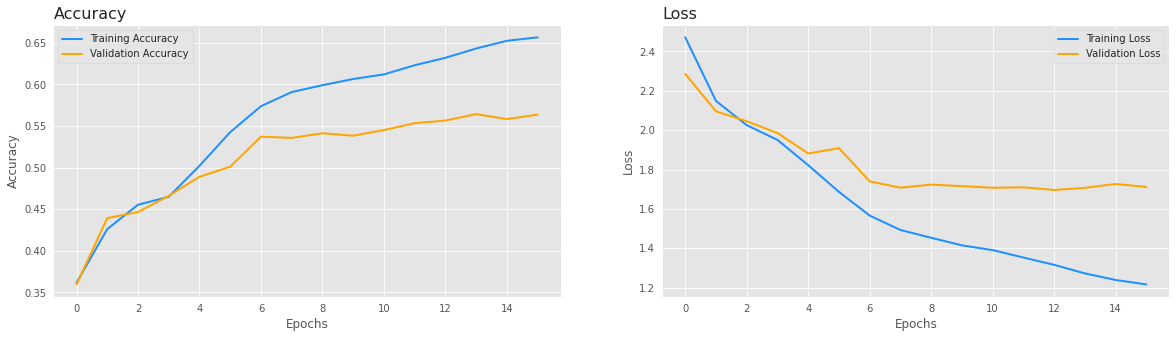

In [44]:
# Plotting the history of the model
plot_history(history)

It is important to see how the model stopped once the validation loss stopped improving, preventing overfitting in the given model. I tried training this model for more epochs, but with both models, the result was overfitting. 

**Note** The model with the Bidirectional layer performed just 0.05% better in the validation test than the fully connected one. Thus, I decided to move forwards with the simplest.

It is also important to plot the confusion matrix of the validation text. This information will tell us how good the model is performing on unseen data (validation dataset).

The overall training accuracy is: 0.554304544830427


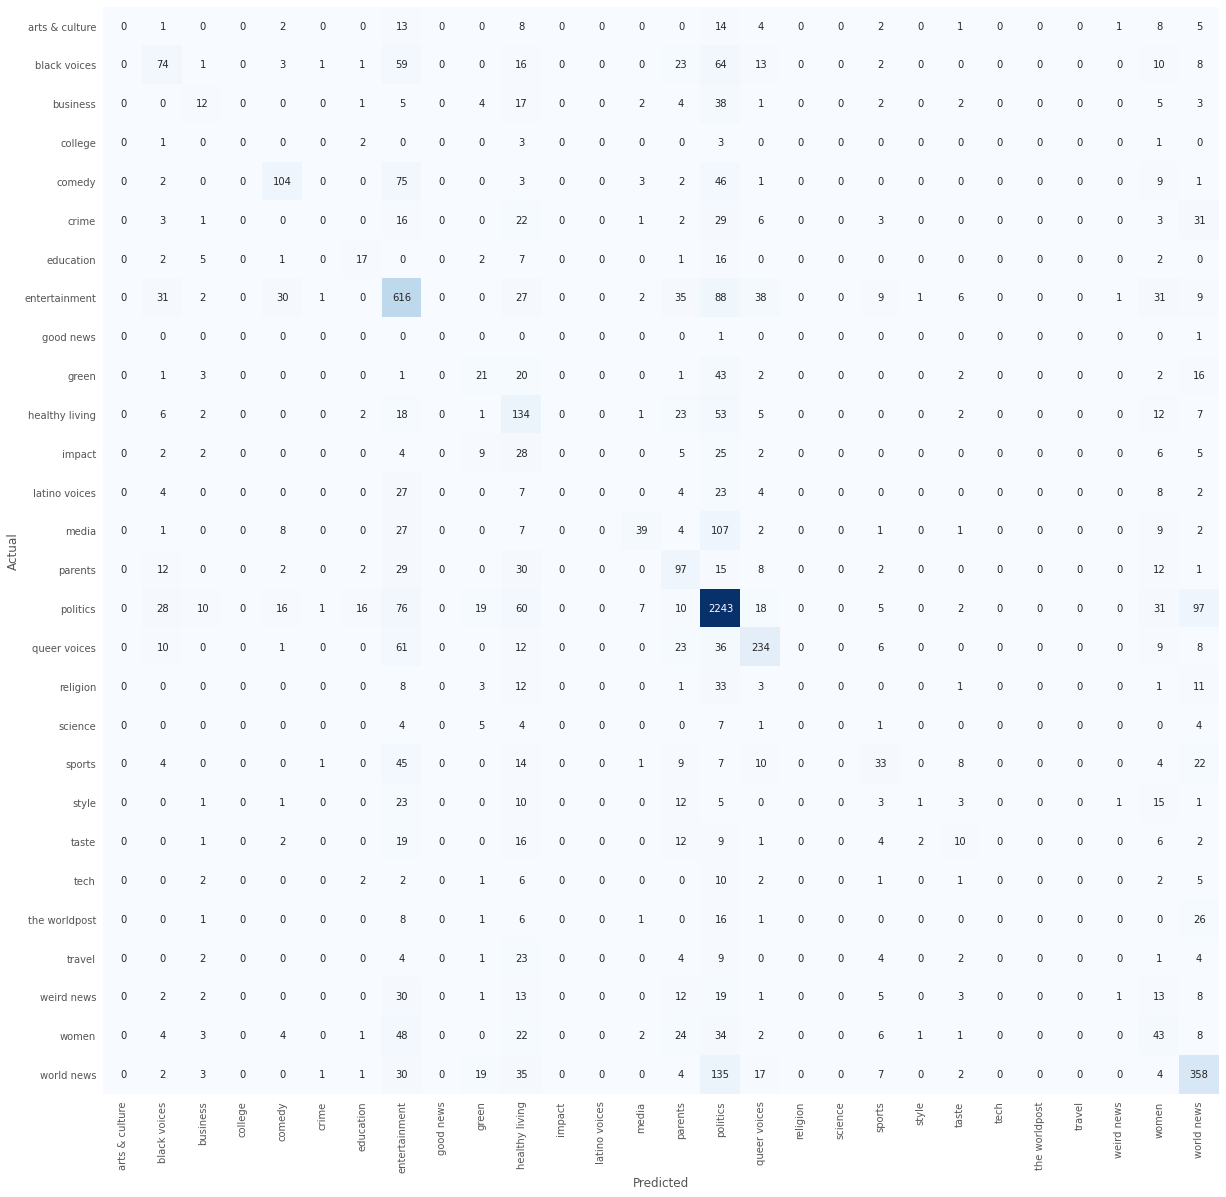

In [45]:
# Confusion matrix
# label_encoder.classes_ show the classes encoded
print('The overall training accuracy is: {}'.format(accuracy_score(pred_val, validation_labels)))
plot_cmatrix(pred_val, label_encoder.classes_, 20, validation_labels)

The overall accuracy in the training set was of 0.554% and 0.6566% for the training set. This is not a perfect result but is good for such simpler model. To improve these results, It might be possible to imcrease the complexity of the model with regularization techniques. The aforementioned would allow the improvement of the model's accuracy. Similarly, the confusion matrix shows how the `categories` "politics", "entertainmente" and "world news" were the ones with the best classification results. For the first two categories mentioned, the categories "politics", "entertainmente" possesses a broader number of samples, resulting in more examples for this particular class. It is possible to see how there are categories like "the worldpost" or "travel" that never had a match. The information previously mentiones is result of the imbalance in the dataset, particularly, the imbalance in our small subset of data.

More metrics are printed below. These are the Precision, Recall, F1-Score and Support. This information complements the confusion matrix and allows for a deeper analysis.

In [37]:
# Printing all the metrics
print(classification_report(pred_val, validation_labels, target_names = label_encoder.classes_))

                precision    recall  f1-score   support

arts & culture       0.05      0.16      0.07        19
  black voices       0.30      0.38      0.34       245
      business       0.11      0.17      0.14        70
       college       0.00      0.00      0.00         0
        comedy       0.56      0.57      0.57       266
         crime       0.29      0.23      0.26       160
     education       0.31      0.36      0.33        50
 entertainment       0.61      0.58      0.60      1070
     good news       0.00      0.00      0.00         0
         green       0.11      0.15      0.13        91
healthy living       0.39      0.38      0.38       303
        impact       0.01      0.07      0.02        14
 latino voices       0.00      0.00      0.00         6
         media       0.43      0.33      0.38       293
       parents       0.42      0.52      0.46       186
      politics       0.81      0.72      0.76      3259
  queer voices       0.61      0.58      0.59  

/home/sherlock/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



Besides the last metrics, I wanted to see the number of good classifications per class, to do so the following cell print the results.

In [46]:
class_correct = list(0. for i in range(len(np.unique(labels))))
class_total = list(0. for i in range(len(np.unique(labels))))
# For loop to count the number of matches per class
for i in range(len(validation_labels)):
    # current target's label
    label = validation_labels[i]
    if validation_labels[i] == pred_val[i]:
        class_correct[label] += 1
    # Sum label
    class_total[label] += 1
        
for i in range(len(np.unique(labels))):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(label_encoder.classes_[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of arts & culture:  0% ( 0/59)
Test Accuracy of black voices: 26% (74/275)
Test Accuracy of business: 12% (12/96)
Test Accuracy of college:  0% ( 0/10)
Test Accuracy of comedy: 42% (104/246)
Test Accuracy of crime:  0% ( 0/117)
Test Accuracy of education: 32% (17/53)
Test Accuracy of entertainment: 66% (616/927)
Test Accuracy of good news:  0% ( 0/ 2)
Test Accuracy of green: 18% (21/112)
Test Accuracy of healthy living: 50% (134/266)
Test Accuracy of impact:  0% ( 0/88)
Test Accuracy of latino voices:  0% ( 0/79)
Test Accuracy of media: 18% (39/208)
Test Accuracy of parents: 46% (97/210)
Test Accuracy of politics: 84% (2243/2639)
Test Accuracy of queer voices: 58% (234/400)
Test Accuracy of religion:  0% ( 0/73)
Test Accuracy of science:  0% ( 0/26)
Test Accuracy of sports: 20% (33/158)
Test Accuracy of style:  1% ( 1/76)
Test Accuracy of taste: 11% (10/84)
Test Accuracy of  tech:  0% ( 0/34)
Test Accuracy of the worldpost:  0% ( 0/60)
Test Accuracy of travel:  0% ( 0/54)

To summarize, the last cell presented the number of matches per class giving the total number of samples. This information allows for a better understanding of the model and its performance. It also confirms how the model classified the `category` "politics" with the highest accuracy (84%). From this analysis I conclude that the model is capable to classify the sub-sampled dataset with roughly a 55% of accuracy. Further improvements as the ones mentioned avobe could be applied for further developments.

# Second point

¿Existen estilos de escritura asociados a cada categoría?

To analize the writing style of the authors, I will use a wordCloud's plot. With this cloud I pretend to analize the top 10 most used words by `category` and thus give insights about the writing styles. I consider that this is a very simple approach as it relates the writing style to the words used in a text. For example, I use a lot the word "insight", that word is in my writing style and therefore might be considered as a key factor to analize this question. Based on the last analysis I aim to find the most used words in each category. However, complex analysis should be performed as analyzing the structure of the writing, word order, etc.

A fancier approach would be to use a Neural network to generate text giving it a particular category. The generated text should have a particular style based on the category, however, I do not have enough time to implement it :(

First of all, I will list all the authors in the dataframe.

In [48]:
# Make a copy of the dataset
category_df = f_articles.copy()

print('The Categories in the dataset are: \n')
# Obtain unique categories
categories = category_df.category.unique()
print(categories)
print('The total number of features are: {}'.format(len(categories)))

The Categories in the dataset are: 

['healthy living' 'queer voices' 'world news' 'politics' 'entertainment'
 'comedy' 'black voices' 'green' 'impact' 'latino voices' 'business'
 'women' 'weird news' 'taste' 'crime' 'media' 'parents' 'travel'
 'arts & culture' 'tech' 'education' 'sports' 'religion' 'science' 'style'
 'the worldpost' 'college' 'good news']
The total number of features are: 28


Now I will count the number of times a particular category is repeated in the dataset. 

In [49]:
# Counting unique items
item_counts = category_df[["category"]].value_counts(sort=True).reset_index()
# Drop annoyng index
print(item_counts[:10])

         category     0
0        politics  8797
1   entertainment  3089
2      world news  2061
3    queer voices  1332
4    black voices   916
5  healthy living   886
6          comedy   821
7         parents   699
8           media   694
9           women   678


This information printed above relates to the analysis performed in the previous task as "politics" is the most frequen category folllowed by "entertainment".

Now I will used the method `category_ngram` to see the most used words in the category "politics" To do this analysis, I will dig in our custom feature "full_text" as this might have more useful text information.

In [50]:
# Counting repeated words in the politics category
cat_df = category_ngram('politics', 1, category_df, 'category', 'full_text')
# Transforming the result in a tuplr for visualization purpose
cat_tuple = [tuple(x) for x in cat_df.values]
print(cat_df)

       index  frequency
0      trump       4634
1        say       1985
2  president        971
3      state        838
4     donald        833
5      house        828
6         us        780
7      white        724
8        new        721
9        gop        634


It is ironic to see how the top-3 most frequent words in the category "politics" are "Trump", "say" and "president". This makes a lot of sense as the "politics" category must be talking about presidents, states and so on. Moreover, the other frequent words are strongly related to "politics". The conclusion of this short analysis is that most of the writters of the "politics" category share the common words mentioned above and probably, their writing style is very similar.

Now I want to show a word cloud for the previous category. This is done through the next cell.

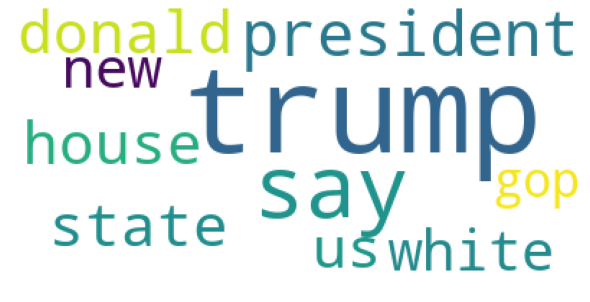

In [51]:
# Create and generate a word cloud image:
wordcloud = WordCloud(max_words = 200, background_color ='white', stopwords = stop_words).generate_from_frequencies(dict(cat_tuple))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

This is the same information as the one printed earlier for the category "politics" however, it is important to visualize it in a aesthetic way. 

Now is time to think bigger. Due to the amount of categories in our sampled dataset (28), I decided to create a word cloud for the 12 more frequent categories. This is performed following similar steps as the ones carried out. To clean the code, the whole method is implemented in `display_wordcloud`.

/home/sherlock/Desktop/whale_jaguar_test/utils.py:77: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



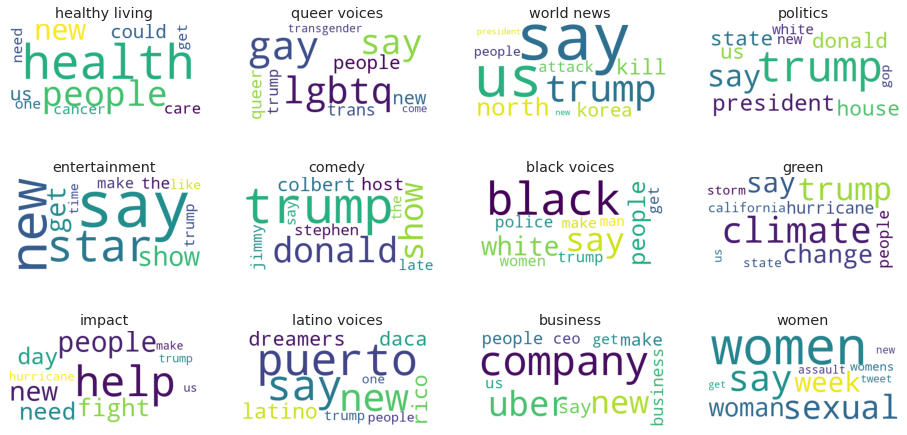

In [53]:
# Display 12 word clouds with the top-10 most used categories of the top-12 most frequent categories.
display_wordcloud(category_df, stop_words, 12, feature2filter = 'category', varText = 'full_text')

I will analyse some of the styles presented above, however, there is a lot to do! I will not analyze again the style in "politics" as this was already discussed. Nevertheless, It is important to mentiones that the words "trump" and "donal" are also used in the category "comedy". This is due to the number of comediands that like to joke about Trump (which is catually funny). A really interesting insight about the aforementioned is that the writing style of politicians share in common some words, which is indeed interesting.

Now, the writing style of "latino voices" has some words in spanish such like "puerto", "rico" and "latino". Maybe, the writters of this category think that most of the latinos are from Puertorico, which end up being a writing style among the writers of the "latino voices"' category (Trump is also here). Something interesting happens with the category "women" as besides the common words "women", "woman" there are also some like "assault" and "sexual". The past words portraits how the writers of the "women" category use a lot the words "assault" and "sexual" which in my opinion, is not a good thing.

The category "health living" use common words related to health talks which is not surprising at all, as the writing style of its authors shoulg contain these words. Another interesting one is "queer voices" and the use of words like "gay", "lgbtq", "trans". The last pattern show how most of the text of this category has to contain this words... a very particular writing style indeed.

I could go further but there is a lot to say. I hope that the last analysis let the idea behind the writing analysis based on words clear.

# Third Point

¿Qué se puede decir de los autores a partir de los datos?

To dig into this point I will use the word cloud used before, as in my opinion, authors might share writing styles (words). Finally, a barplot with the top-3 most used words by author will be used to finish the analysis.

In [44]:
# Removing long sequences of authors
def trim_string(text):
    # Obtain only the first element in the authors' column
    splitted_text = text.split(',')[0]
    return splitted_text

In [45]:
# Make a copy of the dataset
authors_df = f_articles.copy().reset_index(drop=True)

authors_df['authors'] = authors_df['authors'].apply(trim_string)
# Remove empty strings
authors_df['authors'].replace('', np.nan, inplace=True)
authors_df.dropna(subset=['authors'], inplace=True)

print('The Authors in the dataset are: \n')
authors = authors_df.authors.unique()
print(authors)
print('The total number of features are: {}'.format(len(authors)))

The Authors in the dataset are: 

['Mycah Hazel' 'Elyse Wanshel' 'Sara Hylton' ... 'Phu Nguyen'
 'Emily Kalah Gade' 'Anna Sabino']
The total number of features are: 3758


In [46]:
# Count number of times an author is repeated
authors_count = authors_df[["authors"]].value_counts(sort=True).reset_index()
# Check first 10 sampples
print(authors_count[:10])

               authors    0
0            Lee Moran  906
1       Mary Papenfuss  601
2             Ed Mazza  576
3           Ron Dicker  554
4       Curtis M. Wong  427
5       Jenna Amatulli  393
6           David Moye  386
7      Rebecca Shapiro  327
8  Dominique Mosbergen  321
9          Doha Madani  298


/home/sherlock/Desktop/whale_jaguar_test/utils.py:77: MatplotlibDeprecationWarning:

Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.



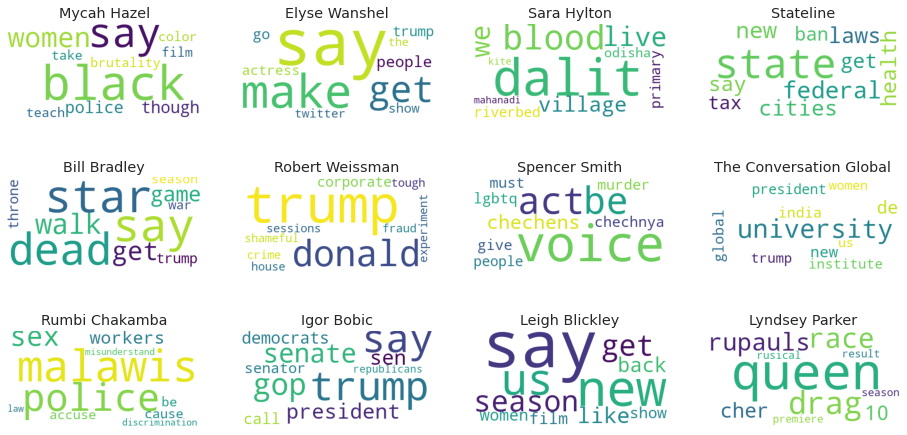

In [47]:
# WordCloud for the top 12 most common authors
display_wordcloud(authors_df, stop_words, 12, feature2filter = 'authors', varText = 'full_text')

In [48]:
# Displaying common words of 'Mary Papenfuss' and frequency
aut_df = category_ngram('Mary Papenfuss', 1, authors_df, 'authors', 'full_text')
aut_df

,index,frequency
0,trump,307
1,say,209
2,president,53
3,call,51
4,donald,49
5,house,47
6,white,45
7,report,44
8,new,43
9,go,39


In [49]:
# Create dataframe with words' frequency per author
aut_words_df = aut_frequency(iterations = 8, authors_name_dic = authors_count, full_authors_df = authors_df, max_words = 3)
aut_words_df

,authors,trump,donald,get,say,president,host,show,new,gay,people,man,news
0,Lee Moran,485,288,105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Mary Papenfuss,307,0,0,209.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Ed Mazza,281,0,0,90.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ron Dicker,0,0,55,152.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0
4,Curtis M. Wong,0,0,0,101.0,0.0,0.0,0.0,95.0,90.0,0.0,0.0,0.0
5,Jenna Amatulli,63,0,0,125.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0
6,David Moye,64,0,0,151.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0
7,Rebecca Shapiro,108,0,0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0


In [50]:
word_df = aut_words_df.copy()
word_df.drop('authors', axis=1, inplace=True)
word_df

,trump,donald,get,say,president,host,show,new,gay,people,man,news
0,485,288,105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,307,0,0,209.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,281,0,0,90.0,0.0,91.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,55,152.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,101.0,0.0,0.0,0.0,95.0,90.0,0.0,0.0,0.0
5,63,0,0,125.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0
6,64,0,0,151.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0,0.0
7,108,0,0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0


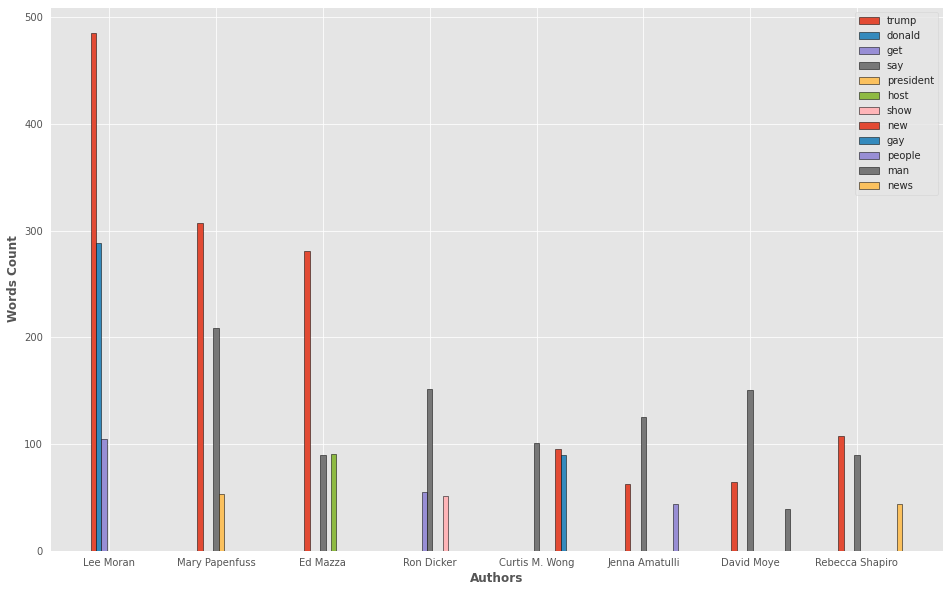

In [51]:
plot_bars_authors(words_df = word_df, authors_df = aut_words_df)

## Fifth point

Targets and labels for new training

In [52]:
# Visualizing short description
# Use plotly to see the distribution of categorical data
# https://www.kaggle.com/vikashrajluhaniwal/recommending-news-articles-based-on-read-articles#6.-Headline-based-similarity-on-new-articles
fig = ff.create_distplot([news_category['short_description'].str.len()], ["ht"], show_hist=False, show_rug=False)
fig['layout'].update(title={'text':'Distribution for Description lenght', 'y':0.9, 'x':0.5, 'xanchor': 'center','yanchor': 'top'}, xaxis_title="Length of Description",yaxis_title="Frecuency")
fig.update_layout(showlegend = False, width=500,height=500)
plotly.offline.plot(fig, filename = 'short_description.html')

'short_description.html'

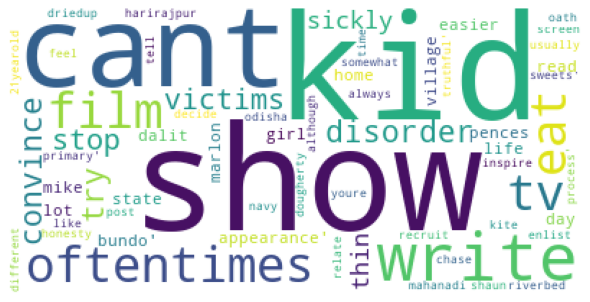

In [53]:
# Make a copy of the dataset
shortd_df = f_articles.copy()

text_description = shortd_df['short_description'].values 
wordcloud = WordCloud(max_words = 200, background_color ='white', stopwords = stop_words).generate(str(text_description))
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [54]:
# Targets
seq_des = np.array([text for text in f_articles['short_description']])
# Labels
labels_des = np.array([label for label in f_articles['category']])

In [55]:
print(seq_des.shape)
print(seq_des[0])

(24274,)
oftentimes film tv show eat disorder try convince victims stop show sickly thin appearance


In [56]:
# Encoding categories
label_encoder_des = LabelEncoder()
# Fir the encoder
labels_des = label_encoder_des.fit_transform(labels_des)

In [57]:
print('The lenght of the labels are: {}'.format(len(np.unique(labels_des))))
print('The labels are: {}'.format(np.unique(labels_des)))

The lenght of the labels are: 28
The labels are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [58]:
# Parameters
# Size of the vocabulary
vocab_size = 2000
# Dimmension of the embedding 
embedding_dim = 128
# LSTM dim
lstm_dim = 32
# hidden dim (fully connected)
hidden_dim = 64
# Maximum lenght of the tokenized vector
max_length = 120
# Padd the vector after the sequence
padding_type ='post'
# Used to replace out-of-vocabulary words
oov_tok = "<OOV>"

In [59]:
# split the dataset
train_sentences, validation_sentences, train_labels, validation_labels = train_test_split(seq_des, labels_des, 
                                                                                          test_size = 0.33, 
                                                                                          stratify = labels_des)

In [60]:
# Transform text into a vector
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
# Fir to the train sequence
tokenizer.fit_on_texts(train_sentences)
# Dictionary with the index of each word
word_index = tokenizer.word_index

# Transform train dataset to sequence 
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# Pad the sequence to the desired shape (given above)
train_padded = pad_sequences(train_sequences, padding = padding_type, maxlen = max_length)

# Vectorize and Padd validation dataset
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding = padding_type, maxlen = max_length)

In [61]:
type(train_padded)

numpy.ndarray

In [62]:
# Model definition
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    # Flat Dimension
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)), # Output of LSTM is Batch x Net out x 2
    tf.keras.layers.Dense(hidden_dim, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(labels_des)), activation='softmax')
])

# Compiling the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 128)          256000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 28)                1820      
Total params: 303,196
Trainable params: 303,196
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
# Callback for early stopping after val stop improving
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Train the model
num_epochs = 50
history = model.fit(train_padded, train_labels, 
                    epochs = num_epochs, verbose=2, 
                    validation_split=0.33, callbacks= [early_stop])

# Predict over the validation test
pred_val = model.predict(validation_padded)
pred_val = np.array([np.argmax(i) for i in pred_val])

Epoch 1/50
341/341 - 8s - loss: 2.4053 - accuracy: 0.3805 - val_loss: 2.2003 - val_accuracy: 0.4138
Epoch 2/50
341/341 - 6s - loss: 2.0930 - accuracy: 0.4435 - val_loss: 2.1014 - val_accuracy: 0.4366
Epoch 3/50
341/341 - 7s - loss: 1.9269 - accuracy: 0.4805 - val_loss: 2.0773 - val_accuracy: 0.4461
Epoch 4/50
341/341 - 6s - loss: 1.7761 - accuracy: 0.5162 - val_loss: 2.0553 - val_accuracy: 0.4546
Epoch 5/50
341/341 - 6s - loss: 1.6278 - accuracy: 0.5536 - val_loss: 2.1098 - val_accuracy: 0.4353
Epoch 6/50
341/341 - 6s - loss: 1.4912 - accuracy: 0.5857 - val_loss: 2.1831 - val_accuracy: 0.4362
Epoch 7/50
341/341 - 6s - loss: 1.3592 - accuracy: 0.6199 - val_loss: 2.3020 - val_accuracy: 0.4362


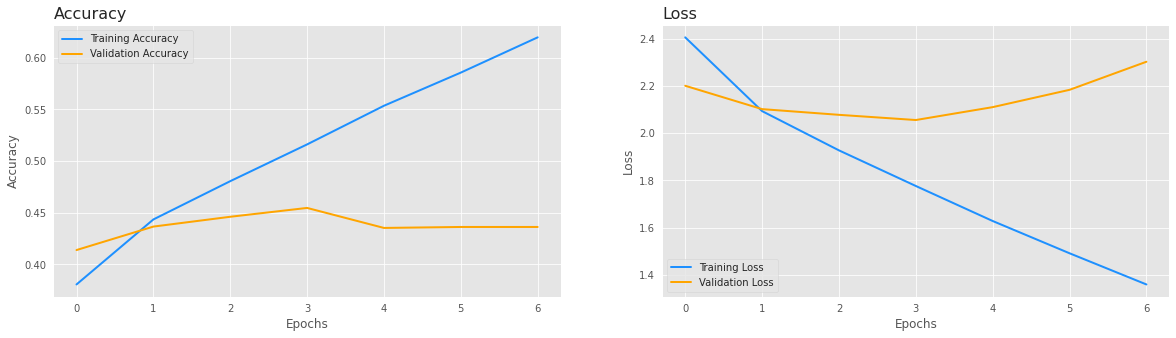

In [64]:
# Plotting the history of the model
plot_history(history)

The overall training accuracy is: 0.4270378229933841


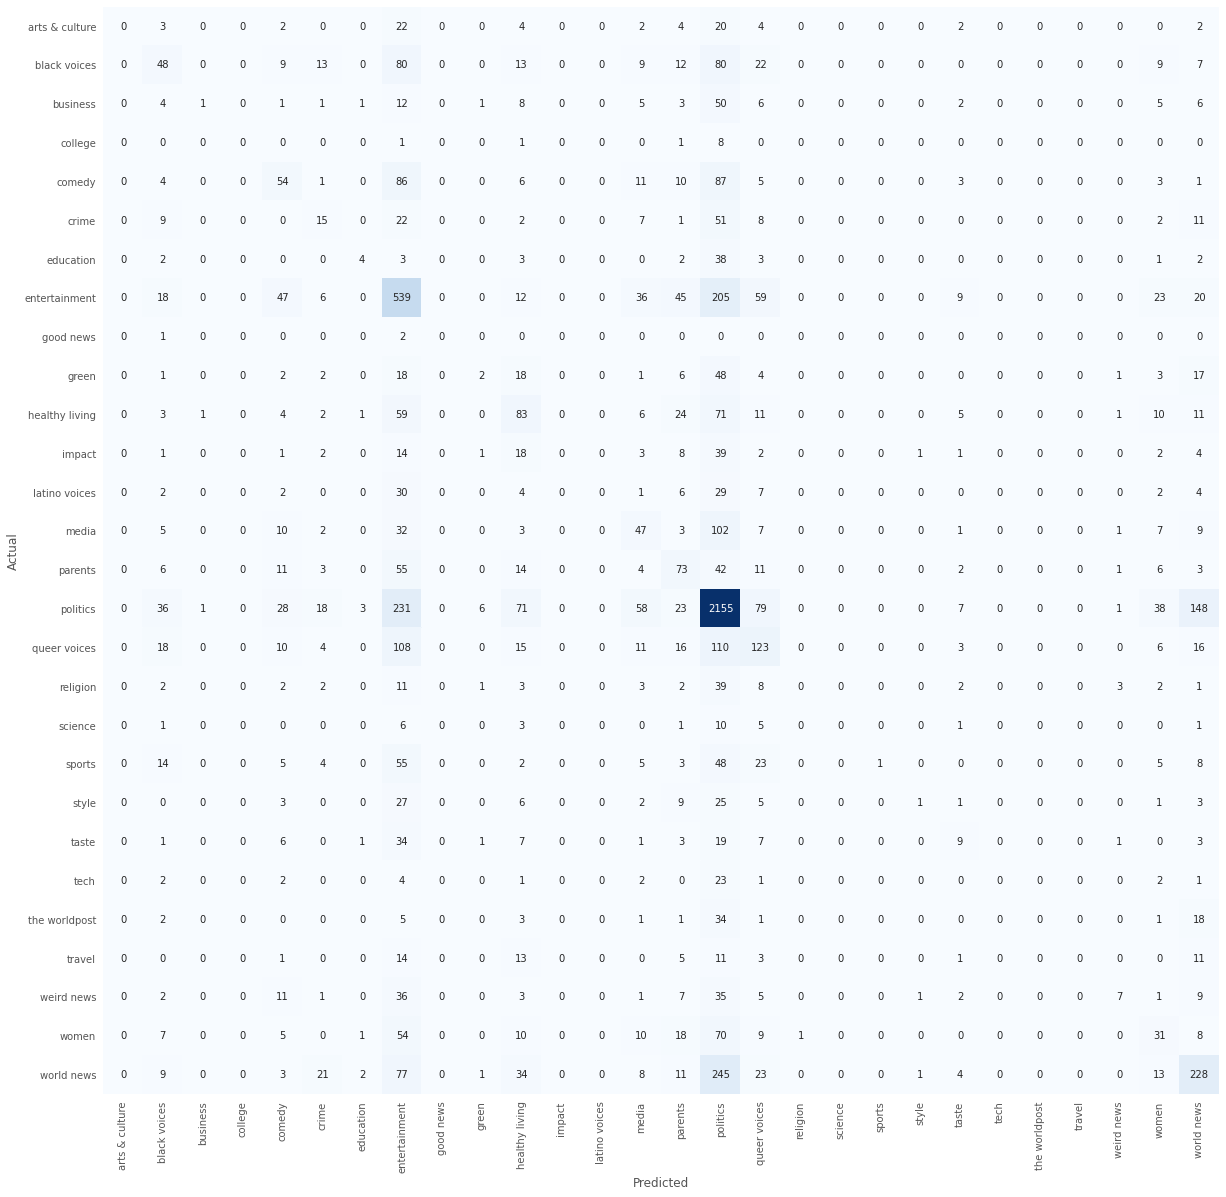

In [65]:
# Confusion matrix
# label_encoder.classes_ show the classes encoded
print('The overall training accuracy is: {}'.format(accuracy_score(pred_val, validation_labels)))
plot_cmatrix(pred_val, label_encoder_des.classes_, 20, validation_labels)

In [66]:
# Printing all the metrics
print(classification_report(pred_val, validation_labels, target_names = label_encoder_des.classes_))

                precision    recall  f1-score   support

arts & culture       0.00      0.00      0.00         0
  black voices       0.16      0.24      0.19       201
      business       0.01      0.33      0.02         3
       college       0.00      0.00      0.00         0
        comedy       0.20      0.25      0.22       219
         crime       0.12      0.15      0.13        97
     education       0.07      0.31      0.11        13
 entertainment       0.53      0.33      0.41      1637
     good news       0.00      0.00      0.00         0
         green       0.02      0.15      0.03        13
healthy living       0.28      0.23      0.25       360
        impact       0.00      0.00      0.00         0
 latino voices       0.00      0.00      0.00         0
         media       0.21      0.20      0.20       234
       parents       0.32      0.25      0.28       297
      politics       0.74      0.58      0.65      3694
  queer voices       0.28      0.28      0.28  

/home/sherlock/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [67]:
class_correct = list(0. for i in range(len(np.unique(labels_des))))
class_total = list(0. for i in range(len(np.unique(labels_des))))
# For loop to count the number of matches per class
for i in range(len(validation_labels)):
    # current target's label
    label = validation_labels[i]
    if validation_labels[i] == pred_val[i]:
        class_correct[label] += 1
    # Sum label
    class_total[label] += 1
        
for i in range(len(np.unique(labels_des))):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(label_encoder_des.classes_[i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

Test Accuracy of arts & culture:  0% ( 0/65)
Test Accuracy of black voices: 15% (48/302)
Test Accuracy of business:  0% ( 1/106)
Test Accuracy of college:  0% ( 0/11)
Test Accuracy of comedy: 19% (54/271)
Test Accuracy of crime: 11% (15/128)
Test Accuracy of education:  6% ( 4/58)
Test Accuracy of entertainment: 52% (539/1019)
Test Accuracy of good news:  0% ( 0/ 3)
Test Accuracy of green:  1% ( 2/123)
Test Accuracy of healthy living: 28% (83/292)
Test Accuracy of impact:  0% ( 0/97)
Test Accuracy of latino voices:  0% ( 0/87)
Test Accuracy of media: 20% (47/229)
Test Accuracy of parents: 31% (73/231)
Test Accuracy of politics: 74% (2155/2903)
Test Accuracy of queer voices: 27% (123/440)
Test Accuracy of religion:  0% ( 0/81)
Test Accuracy of science:  0% ( 0/28)
Test Accuracy of sports:  0% ( 1/173)
Test Accuracy of style:  1% ( 1/83)
Test Accuracy of taste:  9% ( 9/93)
Test Accuracy of  tech:  0% ( 0/38)
Test Accuracy of the worldpost:  0% ( 0/66)
Test Accuracy of travel:  0% ( 0/59)

## Fourth Point

In [126]:
# Clustering Algorithm
# http://brandonrose.org/clustering
from sklearn.cluster import KMeans
# Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [188]:
# Reset indexes
f_articles = f_articles.reset_index(drop=True)
f_articles.head()

,category,headline,authors,link,short_description,date,full_text
0,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18,to bone didnt teach glamour teach respect ofte...
1,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02,will grace creator donate gay bunny book every...
2,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31,we blood invisible live indias dalit women gir...
3,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19,wannacry ransomware attack raise alarm bell ci...
4,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20,walk dead reportedly cancel comiccon press eve...


In [189]:
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])

In [190]:
seq_text.shape

(24274,)

In [191]:
#seq_text = seq_text[:500]
#labels = labels[:500]

In [192]:
# Now vectorize using Tfid
vectorizer = TfidfVectorizer(stop_words='english')
# Transform the 'full_text' string
X = vectorizer.fit_transform(seq_text)

In [193]:
# Define number of Clusters
number_of_clusters = 10
# https://gertjanvandenburg.com/blog/autoencoder/
model = KMeans(n_clusters = number_of_clusters, 
               init = 'k-means++', 
               max_iter = 100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init = 1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
model.fit(X)

KMeans(max_iter=100, n_clusters=10, n_init=1)

In [194]:
# Obtain the indexes of the clusters' features from maximum to minumum (Most important features ahead)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# Obtain features' name
terms = vectorizer.get_feature_names()

In [195]:
# Print most common words per cluster
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 health
 care
 tax
 gop
 senate
 republicans
 repeal
 plan
 obamacare
 cut
Cluster 1:
 new
 time
 state
 women
 know
 like
 come
 black
 school
 day
Cluster 2:
 im
 say
 trump
 like
 know
 ive
 time
 sure
 tell
 dont
Cluster 3:
 trump
 donald
 president
 white
 house
 say
 administration
 tweet
 russia
 new
Cluster 4:
 say
 trump
 new
 police
 house
 want
 white
 state
 time
 tell
Cluster 5:
 make
 trump
 say
 new
 history
 want
 like
 people
 america
 change
Cluster 6:
 years
 ago
 new
 prison
 sentence
 say
 time
 20
 old
 10
Cluster 7:
 news
 fox
 trump
 fake
 roundup
 2017
 host
 say
 media
 report
Cluster 8:
 people
 say
 kill
 trump
 white
 want
 new
 lgbtq
 vote
 young
Cluster 9:
 sexual
 harassment
 misconduct
 assault
 allegations
 accuse
 women
 abuse
 say
 weinstein


In [196]:
# Text index
idx = 5
test_x = vectorizer.transform([f_articles['full_text'][idx]])
print('The text to process is: "{}"'.format(f_articles['full_text'][idx]))
cluster = model.predict(test_x)[0]
print("Text belongs to cluster number {0}".format(cluster))

The text to process is: "voter fraud executive order trump fraud democracy horrify disgust shameful word come mind president donald trump transparent attempt"
Text belongs to cluster number 3


trata de identificar temas,
“protagonistas” u otras entidades de las noticias.

In [198]:
#set up colors per clusters using a dict
cluster_colors = {0: '#8B0000', 
                  1: '#FF8C00',
                  2: '#BC8F8F', 
                  3: '#7CFC00', 
                  4: '#E0FFFF',
                  5: '#008080', 
                  6: '#000000',
                  7: '#DA70D6', 
                  8: '#3CB371', 
                  9: '#708090'
                 }

#set up cluster names using a dict (main_topic)
cluster_names = {0: 'Desire', 
                 1: 'Health', 
                 2: 'State', 
                 3: 'Family', 
                 4: 'Violence',
                 5: 'Leisure', 
                 6: 'Diplomacy', 
                 7: 'Culture', 
                 8: 'News', 
                 9: 'Young',
                 }
                    
clusters = model.labels_.tolist()

In [199]:
topics = {'main_topic': []}
for whole_text in f_articles['full_text']:
    test_x = vectorizer.transform([whole_text])
    cluster_obt = model.predict(test_x)[0]
    topics['main_topic'].append(cluster_names[cluster_obt])

In [200]:
# Create dataframe out of dictionary
topics_df = pd.DataFrame.from_dict(topics)
# Concat the topics dataframe to the original one
final_df = pd.concat([f_articles, topics_df], axis=1, sort=False)
final_df.head()

,category,headline,authors,link,short_description,date,full_text,main_topic
0,healthy living,to bone didnt teach glamour teach respect,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,oftentimes film tv show eat disorder try convi...,2017-07-18,to bone didnt teach glamour teach respect ofte...,Health
1,queer voices,will grace creator donate gay bunny book every...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,lot easier kid mike pences home state read a d...,2018-04-02,will grace creator donate gay bunny book every...,Health
2,world news,we blood invisible live indias dalit women,"Sara Hylton, Women & Girls Hub",https://www.huffingtonpost.com/entry/we-are-th...,girl dalit village harirajpur odisha chase kit...,2017-05-31,we blood invisible live indias dalit women gir...,Health
3,politics,wannacry ransomware attack raise alarm bell ci...,"Stateline, ContributorStateline provides daily...",https://www.huffingtonpost.com/entry/wannacry-...,recent global cyberattack spar federal governm...,2017-05-19,wannacry ransomware attack raise alarm bell ci...,Health
4,entertainment,walk dead reportedly cancel comiccon press eve...,Bill Bradley,https://www.huffingtonpost.com/entry/walking-d...,panel still happen,2017-07-20,walk dead reportedly cancel comiccon press eve...,Health


In [208]:
# Create plot
# Targets
seq_text = np.array([text for text in f_articles['full_text']])
# Labels
labels = np.array([label for label in f_articles['category']])
# Slide through the vector
seq_text = seq_text[:500]
labels = labels[:500]

# Now vectorize using Tfid
vectorizer = TfidfVectorizer(stop_words='english')
# Transform the 'full_text' string
X = vectorizer.fit_transform(seq_text)

# Define number of Clusters
number_of_clusters = 10
# https://gertjanvandenburg.com/blog/autoencoder/
model = KMeans(n_clusters = number_of_clusters, 
               init = 'k-means++', 
               max_iter = 100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init = 1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.
model.fit(X)

# Obtain the indexes of the clusters' features from maximum to minumum (Most important features ahead)
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
# Obtain features' name
terms = vectorizer.get_feature_names()

clusters = model.labels_.tolist()

In [209]:
# Comparing similarity between all the vectors
dist = 1 - cosine_similarity(X)
print(dist.shape)

(500, 500)


In [210]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pos = pca.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [211]:
titles = labels.copy()

In [212]:
print(xs.shape)
print(ys.shape)
print(len(clusters))
print(titles.shape)

(500,)
(500,)
500
(500,)


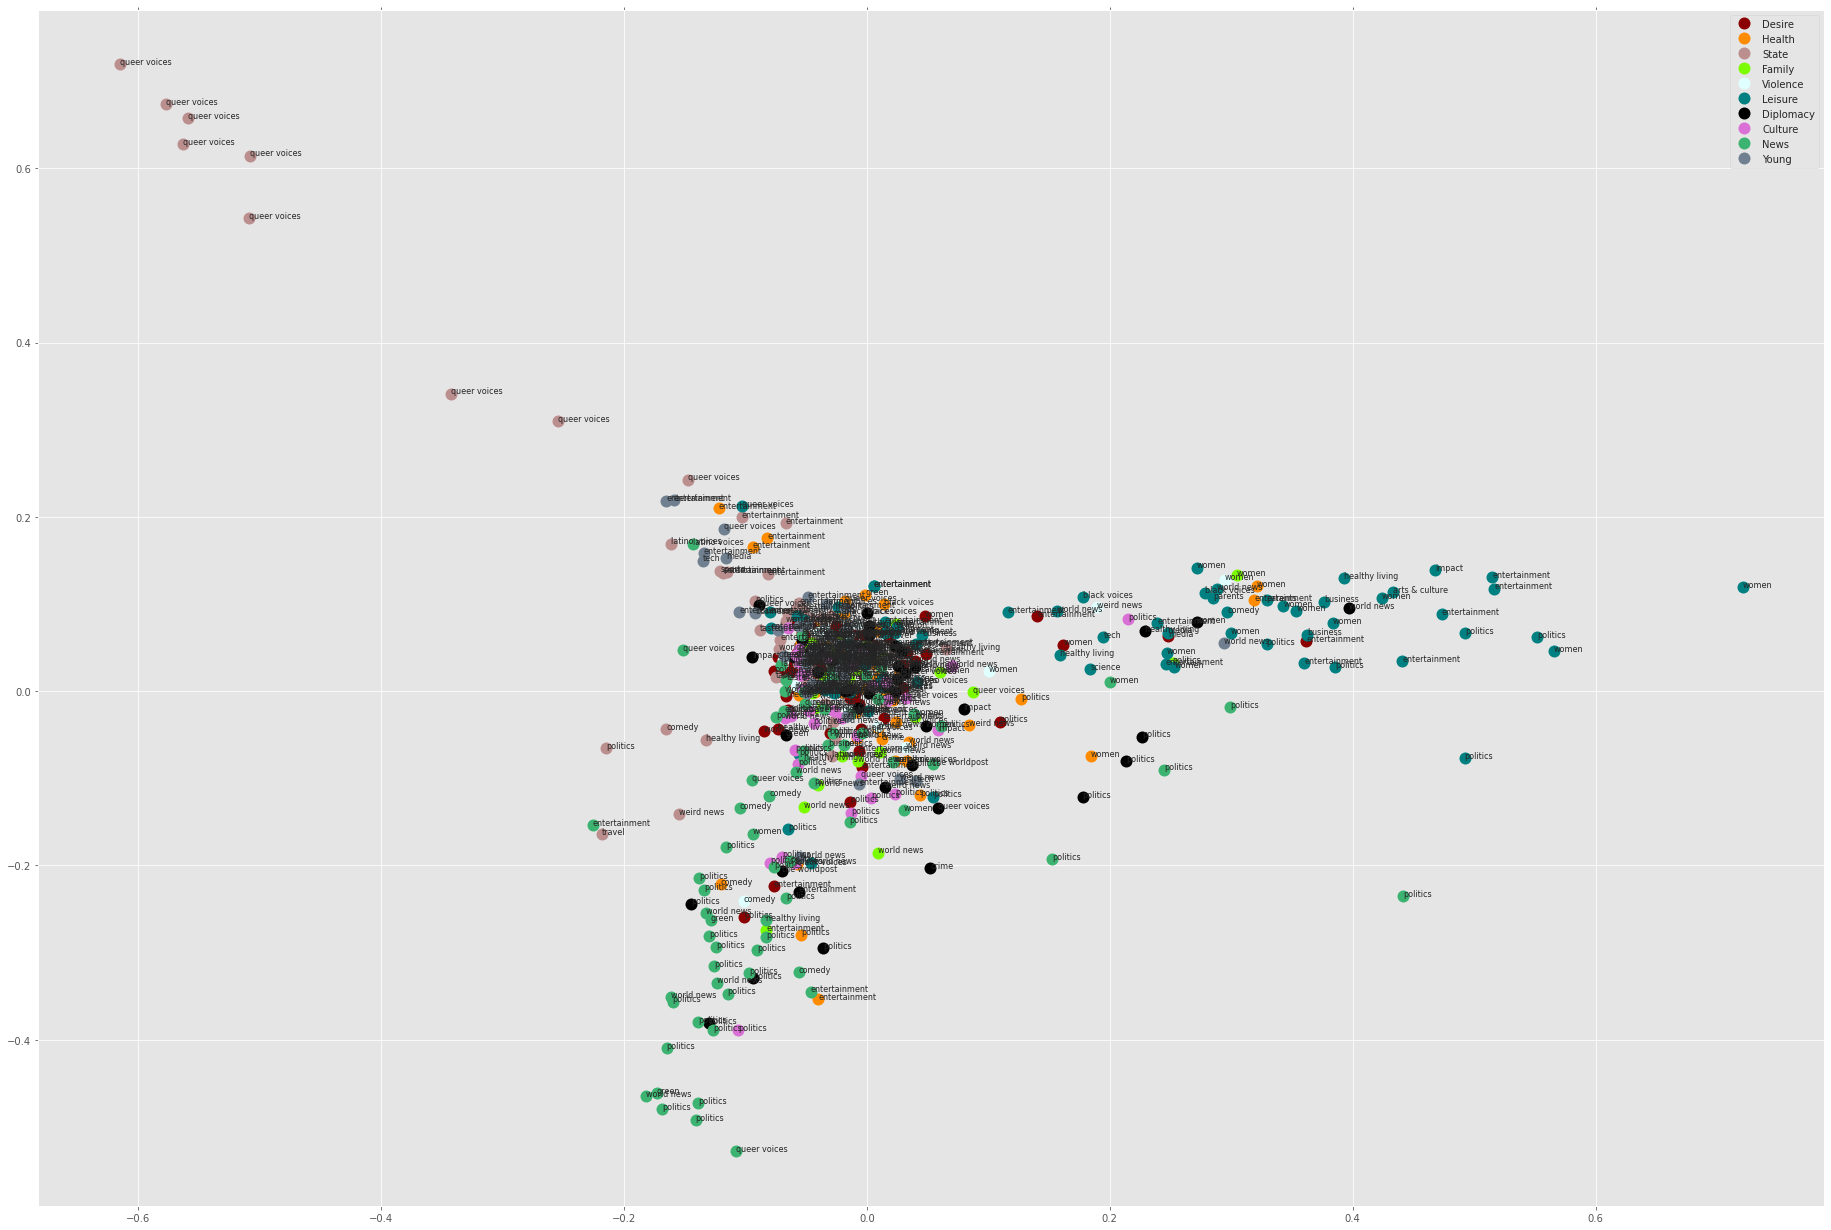

In [215]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(32, 22)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)

# Dendrogram?
plt.show() #show the plot